# Using thermodynamic analysis to guide metabolic engineering
DO 12-6-2018  
Using Python 3 and eQuilibrator API  


In [1]:
#Changing directory to the github home folder /Ctherm_thermo
import os
os.chdir('/Users/satyakam/Dropbox/work/equilibrator-api-master')
import sys
sys.path.append('/Users/satyakam/Dropbox/work/sbtab-0.9.64')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src/equilibrator_api')
sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src')
#sys.path.append('/Users/satyakam/Dropbox/work')


In [2]:
import numpy as np
from numpy import array, eye, log, zeros, matrix
from numpy.linalg import inv, solve
import pandas as pd
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds
%matplotlib inline

## Set up translator for KEGG IDs
Note: I set these up as dataframes because I was troubleshooting an issue with duplicate KEGG IDs. Eventually I think these should be set up as dictionaries, to make the code more readable

In [3]:
# make a dictionary to translate KEGG IDs into human-readable abbreviations
keggTranslatorDf = pd.read_excel('KEGG_SEED_DO.xls')
kt = keggTranslatorDf #short name for easier typing

# translate KEGG ID to long name
ktn = kt.loc[:,['KEGG ID(S)', 'PRIMARY NAME']]
ktn['KEGG ID(S)'] = ktn['KEGG ID(S)'].str.lower() # set to lower case for better matching
ktn.set_index('KEGG ID(S)', inplace = True)

# translate long name to KEGG ID
# the original dictionaries sometimes had trouble with duplicate KEGG IDs. If there are duplicates, make sure to choose the lowest number
ntk = kt.loc[:,['PRIMARY NAME', 'KEGG ID(S)']].sort_values(by = ['KEGG ID(S)'], ascending = True)
ntk['PRIMARY NAME'] = ntk['PRIMARY NAME'].str.lower() # set to lower case for better matching
ntk = ntk.groupby('PRIMARY NAME').first() # take the first KEGG ID in each group

# translate KEGG ID to abbreviation
kta = kt.loc[:,['KEGG ID(S)', 'ABBREVIATION']]
kta['KEGG ID(S)'] = kta['KEGG ID(S)'].str.lower() # set to lower case for better matching
kta.set_index('KEGG ID(S)', inplace = True)

# translate abbreviation to KEGG ID
atk = kt.loc[:,['ABBREVIATION', 'KEGG ID(S)']]
atk['ABBREVIATION'] = atk['ABBREVIATION'].str.lower() # set to lower case for better matching
atk.set_index('ABBREVIATION', inplace = True)

atkDict = dict(zip(atk.index, atk['KEGG ID(S)'].str.upper()))

## Set up model
* Choose reactions
* Set fluxes
* Set concentration bounds
* Set pH and ionic strength

In [4]:
os.chdir('/Users/satyakam/Dropbox/work/component_contribution_ctherm')

In [5]:
allRxnDf = pd.read_excel('cth_thermo_model_DO_SD2.xlsx', sheet_name = 'reactions')
allRxnDf[:5]

,Name,PlaintextFormula,AbbreviationFormula,KeggFormula,Notes,ppi-pfk,atp-pfk,mal-snt,pdc,gapn,pyk,aldh-ndp,adh-ndp,mal-gapn,tsac,test
0,ATPM,H2O + ATP <=> ADP + Phosphate,h2o + atp <=> adp + pi,C00001 + C00002 <=> C00008 + C00009,ATP hydrolysis for cellobiose transport,1,1,1,1,1,1,1,1,1,1,1
1,CBP,Phosphate + Cellobiose <=> D-Glucose + Glucose...,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,NaN,1,1,1,1,1,1,1,1,1,0,1
2,BGL,Cellobiose + H2O <=> 2 D-Glucose,cellb + h2o <=>2 glc-D,C00185 + C00001 <=> 2 C00031,Beta glucosidase,0,0,0,0,0,0,0,0,0,1,0
3,GLK-GTP,D-Glucose + GTP <=> D-Glucose-6-phosphate + GDP,glc-D + gtp <=> g6p + gdp,C00031 + C00044 <=> C00092 + C00035,NaN,1,1,1,1,1,1,1,1,1,0,1
4,GLK-ATP,D-Glucose + ATP <=> D-Glucose-6-phosphate + ADP,glc-D + atp <=> g6p + adp,C00031 + C00002 <=> C00092 + C00008,NaN,0,0,0,0,0,0,0,0,0,2,0


In [6]:
# choose a flux set, and drop all of the zero-flux reactions
# loop over fluxsets to generate multiple models 
selectedRxnDf={}
fluxSet = ['ppi-pfk','mal-snt','test']
for f in range(len(fluxSet)):
    selectedRxnDf[f] = allRxnDf.loc[allRxnDf[fluxSet[f]] != 0, ['Name', 'AbbreviationFormula', 'KeggFormula', fluxSet[f]]]
    selectedRxnDf[f].rename(columns = {fluxSet[f]:'flux'}, inplace = True) # rename the flux columns to 'flux' to simplify subsequent
    #rxnlist[f]= selectedRxnDf  

In [7]:
#Import metabolite data from excel file
Alldata = pd.read_excel('./metabolite_data/lt_dataset2_quantified.xlsx')
Met_data = Alldata.loc[Alldata['Replicate'] != 0, ['Timepoint', 'kegg', 'compound','amount', 'Sample','Replicate']]
#Met_data

In [8]:
# set up the reaction bounds
# make a dataframe with the upper and lower bounds
def bounds_to_df(compounds, bounds):
    """
    Make a dataframe with concentrations
    Args:
        compounds = list of KEGG IDs
        bounds = equilibrator-api bounds object
    """
    boundsDf = pd.DataFrame(compounds, columns = ['Compound:Identifiers:kegg.compound']) # I had to choose this clunky column name to make it work with bounds.py 
                                                                                                    # from_dataframe method
    boundsDf['Name'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: kta.loc[x.lower()]) # add abbreviations
    boundsDf['Concentration:Max'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: bounds.GetUpperBound(x))
    boundsDf['Concentration:Min'] = boundsDf['Compound:Identifiers:kegg.compound'].apply(lambda x: bounds.GetLowerBound(x))
    return boundsDf

In [14]:
saveDirs = ["P1_ppi_ratio"]
ppi_ratio = np.geomspace(0.01, 100, 20)
pi_ratio = [1,2,3,4,5,6,7,8,9,10]
exp_data_file = "ctherm_exp_data.txt"
exp_data = []
all_data = {}
all_data_no_etoh = {}
Uf = 2 #Uncertainity factor 
ref_conc0 = {#'C00469': 1,   #ethanol
            'C00004': 0.08,  #NADH
            'C00024': 0.83,  #Acetyl-CoA
            'C00002': 2.70,  #ATP
            'C00008': 0.11,  #ADP
            'C00020': 0.22,  #AMP
            #'C00354': 1.50,  #FBP
            'C00092': 8.19,  #G6P
            'C00074': 0.69,  #Phosphoenolpyruvate
            'C00005': 0.38,  #NADPH
            'C00022': 12.65, #Pyruvate
            'C00103': 6.66,  #G1P
            'C00044': 0.28,  #GTP
            'C00035': 0.01,  #GDP        
            'C00085': 1.49,  #F6P 
            'C00103': 6.66,  #G1P 
            'C00118': 0.10,  #G3P 
            'C00197': 1.35,  #3PG
            'C00011': 1.27,  #CO2
            'C00003': 2.25,  #NAD 
            'C00006': 0.26,  #NADP 
            'C00010': 0.02,  #CoA
            }
for f in range(len(fluxSet)):
    reactions = []
    for i, row in selectedRxnDf[f].iterrows():
        rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
        if (rxn.check_full_reaction_balancing()):
            reactions.append(rxn)
        else:
            print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
    # create flux list
    fluxes = selectedRxnDf[f]['flux'].values

    # need to declare pH and ionic strength constants at the beginning
    PH = 7.0
    IS = 0.1

    # calculate dGO_r_primes
    dG0_r_primes = []
    for r in reactions:
        result = r.dG0_prime(pH = PH, ionic_strength = IS)
        #print(result)
        dG0_r_primes.append(result)
    pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)    
    all_data[f] = {}
    all_data_no_etoh[f] = {}
    ref_conc = {k: float(v) / 1000 for k,v in ref_conc0.items()}
    ref_t0={};
    dictCur ={}
    # fix PPI/PI ratio
    pp.bounds.SetBounds('C00013', 1e-3 * 1.2,1e-3 * 1.2)
    pp.bounds.SetBounds('C00009', 1e-3 * 10,1e-3 * 10)
    for t in range(3):
        for cpd, conc in ref_conc.items(): # this loop iterates over compound list to genrate bounds for mdf simulation
            pp.bounds.SetBounds(cpd, 1e-6,0.1) # reset bounds at the start of each iteration
            if t == 0 : 
                pp.bounds.SetBounds(cpd, conc / Uf,conc * Uf)
                pp.bounds.SetBounds('C00469', 5/46 , 5/46) # ethanol conc is fixed at the measured value
                for i, dat in Met_data.iterrows():
                    if dat['Sample']=='A' and dat['Timepoint']==2 and dat['Replicate']==1:
                        if dat['kegg'] == cpd:
                            ref_t0[cpd]= dat['amount']           
            elif t == 1 :
                for i, dat in Met_data.iterrows():
                    if dat['Sample']=='A' and dat['Timepoint']==5 and dat['Replicate']==1:
                        if dat['kegg'] == cpd:
                            pp.bounds.SetBounds(cpd, conc * dat['amount'] / (ref_t0[cpd]*Uf),conc * dat['amount'] * Uf/(ref_t0[cpd]))
                        elif dat['kegg'] == 'C00118':
                            pp.bounds.SetBounds(cpd, 0.001,conc * dat['amount'] * Uf/(ref_t0[cpd]))
                            #print(t,dat['amount'],cpd)
                pp.bounds.SetBounds('C00469', 20/46 , 20/46)
            elif t == 2:
                for i, dat in Met_data.iterrows():
                    if dat['Sample']=='A' and dat['Timepoint']==9 and dat['Replicate']==1:
                        if dat['kegg'] == cpd:
                            pp.bounds.SetBounds(cpd, conc * dat['amount'] / (ref_t0[cpd]*Uf),conc * dat['amount'] * Uf/(ref_t0[cpd]))
                        elif dat['kegg'] == 'C00118':
                            pp.bounds.SetBounds(cpd, 0.001,conc * dat['amount'] * Uf/(ref_t0[cpd]))
                            #print(t,dat['amount'],cpd)
                pp.bounds.SetBounds('C00469', 40/46 , 40/46)
            elif cpd in ["C00002","C00008","C00020","C00044","C00035","C00003","C00004","C00005","C00006"]:
                pp.bounds.SetBounds(cpd, conc ,conc)
        mdf_data, con = pp.conc_mdf()

        # store the data
        dictCur[t] = {'mdf': mdf_data.mdf}
        dictCur[t]["reaction prices"] = {r.reaction.reaction_id: float(r.shadow_price) for r in mdf_data.reaction_data}
        dictCur[t]["gibbs energies"] = {r.reaction.reaction_id: float(r.dGr) for r in mdf_data.reaction_data}
        dictCur[t]["concentrations"] = {str(c.compound): float(c.concentration) for c in mdf_data.compound_data}
        dictCur[t]["compound prices"] = {str(c.compound): float(c.shadow_price) for c in mdf_data.compound_data}
        dictCur[t]["compound lower"] = {str(c.compound): float(mdf_data.model.concentration_bounds.GetLowerBound(str(c.compound))) for c in mdf_data.compound_data}
        dictCur[t]["compound upper"] = {str(c.compound): float(mdf_data.model.concentration_bounds.GetUpperBound(str(c.compound))) for c in mdf_data.compound_data}
        dictCur[t]["compound range"] = con

        all_data[f] = dictCur
    #the following loop is for the case with no externally added ethanol case or Sample 'B'
    for t in range(3):
        for cpd, conc in ref_conc.items():
            pp.bounds.SetBounds(cpd, 0.000001,0.01) # reset bounds at the start of each iteration
            if t == 0:
                pp.bounds.SetBounds(cpd, conc / Uf,conc * Uf)
                for i, dat in Met_data.iterrows():
                    if dat['Sample']=='B' and dat['Timepoint']==2 and dat['Replicate']==1:
                        if dat['kegg'] == cpd:
                            ref_t0[cpd]= dat['amount']           
            elif t == 1:
                for i, dat in Met_data.iterrows():
                    if dat['Sample']=='B' and dat['Timepoint']==5 and dat['Replicate']==1:
                        if dat['kegg'] == cpd:
                            pp.bounds.SetBounds(cpd, conc * dat['amount'] / (ref_t0[cpd]*Uf),conc * dat['amount'] * Uf/(ref_t0[cpd]))
                            #print(t,dat['amount'],cpd)
            elif t == 2:
                for i, dat in Met_data.iterrows():
                    if dat['Sample']=='B' and dat['Timepoint']==9 and dat['Replicate']==1:
                        if dat['kegg'] == cpd:
                            pp.bounds.SetBounds(cpd, conc * dat['amount'] / (ref_t0[cpd]*Uf),conc * dat['amount'] * Uf/(ref_t0[cpd]))
                            #print(t,dat['amount'],cpd)
            elif cpd in ["C00002","C00008","C00020","C00044","C00035","C00003","C00004","C00005","C00006"]:
                pp.bounds.SetBounds(cpd, conc ,conc)
        mdf_data, con = pp.conc_mdf()
        # store the data
        dictCur[t] = {'mdf': mdf_data.mdf}
        dictCur[t]["reaction prices"] = {r.reaction.reaction_id: float(r.shadow_price) for r in mdf_data.reaction_data}
        dictCur[t]["gibbs energies"] = {r.reaction.reaction_id: float(r.dGr) for r in mdf_data.reaction_data}
        dictCur[t]["concentrations"] = {str(c.compound): float(c.concentration) for c in mdf_data.compound_data}
        dictCur[t]["compound prices"] = {str(c.compound): float(c.shadow_price) for c in mdf_data.compound_data}
        dictCur[t]["compound lower"] = {str(c.compound): float(mdf_data.model.concentration_bounds.GetLowerBound(str(c.compound))) for c in mdf_data.compound_data}
        dictCur[t]["compound upper"] = {str(c.compound): float(mdf_data.model.concentration_bounds.GetUpperBound(str(c.compound))) for c in mdf_data.compound_data}
        dictCur[t]["compound range"] = con

        all_data_no_etoh[f] = dictCur

In [18]:
import seaborn as sns
sns.set()
fng_data={}
for f in range(2):
    fng_data[r]={}
    for r2 in range(3):
        fng_data[r][r2] = all_data[f][r2]["reaction prices"]
import pandas as pd
df = pd.DataFrame.from_dict(fng_data)
all_data
#sns.heatmap(df)
#xlabel('PPi conc in mM')
#ylabel('timepoints')

{0: {0: {'mdf': 0.7811867453099737,
   'reaction prices': {'ATPM': 0.0,
    'CBP': 5.601242886211647e-18,
    'GLK-GTP': 5.601242886211647e-18,
    'PGMT': 0.0,
    'PGI': 1.1202485772423293e-17,
    'PFK-PPi': 0.07692307692307682,
    'FBA': 0.07692307692307687,
    'TPI': 0.07692307692307687,
    'GAPDH': 0.15384615384615374,
    'PGK-GTP': 0.15384615384615374,
    'PGM': 0.15384615384615374,
    'ENO': 0.15384615384615385,
    'PPDK': -3.3607457317269875e-17,
    'PFOR': 0.0,
    'RNF_PPiase': 0.0,
    'ALDH-NADH': 0.07692307692307687,
    'ADH-NADH': 0.07692307692307687},
   'gibbs energies': {'ATPM': -42.468800124466846,
    'CBP': -0.7811867453099737,
    'GLK-GTP': -13.267522308506027,
    'PGMT': -6.908330680362136,
    'PGI': -1.6970592173483627,
    'PFK-PPi': -0.7811867453099781,
    'FBA': -0.781186745309995,
    'TPI': -0.7811867453099701,
    'GAPDH': -0.7811867453099754,
    'PGK-GTP': -0.7811867453099772,
    'PGM': -0.7811867453099746,
    'ENO': -0.781186745309983,
  

Text(0.5, 1.0, 'MDF vs timepoints')

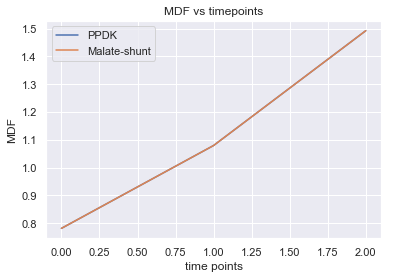

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
mdf_data={}
for k in range(2):
    mdf_data[k]={}
    for t in range(3):
        mdf_data[k][t] = all_data[k][t]["mdf"]
y={}
for k in range(2):
    y[k]={}
    for t in range(3):
        y[k][t] = float(mdf_data[k][t]) 
import pandas as pd
df = pd.DataFrame.from_dict(y)

plt.plot(df)
plt.legend(['PPDK','Malate-shunt'])
plt.xlabel('time points')
plt.ylabel('MDF')
plt.title('MDF vs timepoints')

Text(0.5, 0, 'time points')

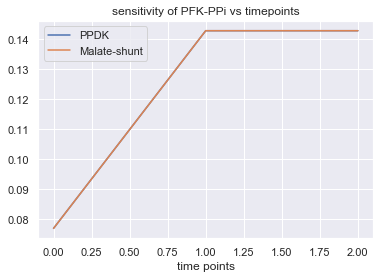

In [12]:
fng_data={}
for k in range(2):
    fng_data[k]={}
    for r in [1]:
        fng_data[k][r]={}
        for t in range(3):
            fng_data[k][t] = all_data[k][t]["reaction prices"]["PFK-PPi"]
z={}
for k in range(2):
    z[k]={}
    for t in range(3):
        z[k][t] = float(fng_data[k][t]) 
import pandas as pd
df = pd.DataFrame.from_dict(z)
plt.plot(df)
plt.legend(['PPDK','Malate-shunt'])
plt.title('sensitivity of PFK-PPi vs timepoints')
plt.xlabel('time points')

,0,1,2
ADH-NADH,7.692308e-02,1.428571e-01,1.428571e-01
ALDH-NADH,7.692308e-02,1.428571e-01,1.428571e-01
ATPM,0.000000e+00,0.000000e+00,0.000000e+00
CBP,3.360746e-17,-4.480994e-17,-1.120249e-17
ENO,1.538462e-01,-3.826530e-17,-3.488897e-17
FBA,7.692308e-02,1.428571e-01,1.428571e-01
GAPDH,1.538462e-01,2.857143e-01,2.857143e-01
GLK-GTP,3.360746e-17,-4.480994e-17,-1.120249e-17
PFK-PPi,7.692308e-02,1.428571e-01,1.428571e-01
PFOR,0.000000e+00,0.000000e+00,0.000000e+00


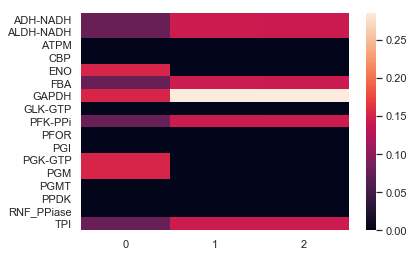

In [34]:
from collections import OrderedDict
fng_data={}
for t in range(3):
    fng_data[t] = all_data[0][t]["reaction prices"]
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)
df

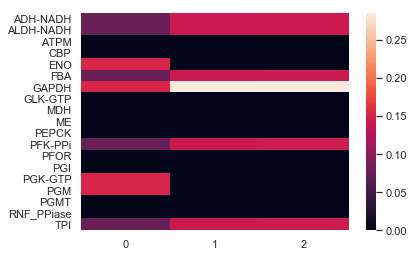

In [25]:
fng_data={}
for t in range(3):
    fng_data[t] = all_data[1][t]["reaction prices"]
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)

In [ ]:
y={}
for t in range(10):
    y[t] = float(mdf_data[6][t]) 
plt.plot(*zip(*sorted(y.items())))
plt.xlabel('timepoints')
plt.ylabel('MDF at PPi conc of 10mM')
plt.title('MDF vs time points')